In [4]:
import pandas as pd
import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora, models
import pandas as pd
from nltk import FreqDist
import re
import spacy
import numpy as np
# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
nltk.download('stopwords')
 # one time run

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\banva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
#!python -m spacy download en
import en_core_web_sm
nlp = en_core_web_sm.load()

In [21]:
reviews = ["I love it. I was looking for a small Dewalt Li. Charger. This one is good for tight spaces or over the wall, and its very efficient charging the batteries.The battery included was a little bit larger than the ones i already have so i had to remove the metal hanger from the drill in order to use the new batte So far no problems, preform as expected. good deal to save your 18 volt tools worked well and easy Works great except with my finish nail gun. Easy to use and a great way to extend the life of the older generation tools. The 20v conversion kit is a great price and value. The new smaller battery is lighter and not as bulky as the 18v batteries. I am so happy that I changed over. The vault see only time I buy the best Worth the cost nice to have a conversion from the old batteries and reuse the original tools. Very pricy, they are making a ton of money on these batteries. I love my speaker so much awesome bass system it\'s exactly what I want Although I have an older corded circular saw, when we began our house remodeling I decided that I wanted to get a cordless saw to use for making quick cuts, be it boards, panels, or trim. I liked the idea of having the saw available whenever or wherever I needed it, without having to worry about stringing out the extension cord, especially for a quick cut or two. Already having several batteries and being a fan of DeWalt, I took a look at their offerings and purchased the DCS391B 20V MAX 6-1/2&quot; Saw. I have been using the saw now for 6 months and I have been extremely pleased with its performance. The saw is lightweight, which I have found makes it much easier to control, especially for long cuts on plywood panels. Although the saw is quiet, it has plenty of power to handle whatever cuts I\'ve needed, from trim pieces to framing lumber and even trimming off the bottoms of wood doors with ease. The shape of the grip handle with its rubber covering is comfortable, while the power trigger safety and trigger switch are both easy to operate. The depth of blade and bevel adj"]

In [22]:
df= pd.DataFrame(reviews,columns=['reviews'] )

In [23]:
df['reviews']

0    I bought the tool without a battery. Who can i...
1    This product is really good, but the handle ne...
Name: reviews, dtype: object

In [24]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

In [25]:
stop_words = stopwords.words('english')


In [26]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

In [27]:
# remove short words (length < 3)
df['reviews'] = df['reviews'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [28]:
df['reviews']

0    bought the tool without battery. Who can ignor...
1    This product really good, but the handle needs...
Name: reviews, dtype: object

In [29]:
# remove stopwords from the text
exp = [remove_stopwords(r.split()) for r in df['reviews']]

In [30]:
exp

['bought tool without battery. Who ignore $20 rebate, got great deal. Three thoughts however, leaning way. And take consideration buy bare tool.1) Get new 6.3 Core battery ordered two). Had thought need one, might ordered bare tool. might looked package--tool, battery, tool bag, etcetera. The 18v slimline battery packs already simply weak work satisfactorily. Did they? Yes, blade moved much slower pace might powerful battery. Online reviews 18v Core batteries--in configuration--argue entire Bosch 18v line tools work much better new improved cells. Additionally, might imagine, slimline batteries allow satisfactory number cuts seizing middle my, know, maybe 12th 2x4.2) Count buying better blade one included. The 6.5 inch circular saw blade included might throw-away anything crudest cuts. And want different blades anyway, cutting plywood dimensional lumber.3) like think lighter battery-operated circular saw would take Bosch batteries. But pretty wedded brand, save couple Dewalt saws. love

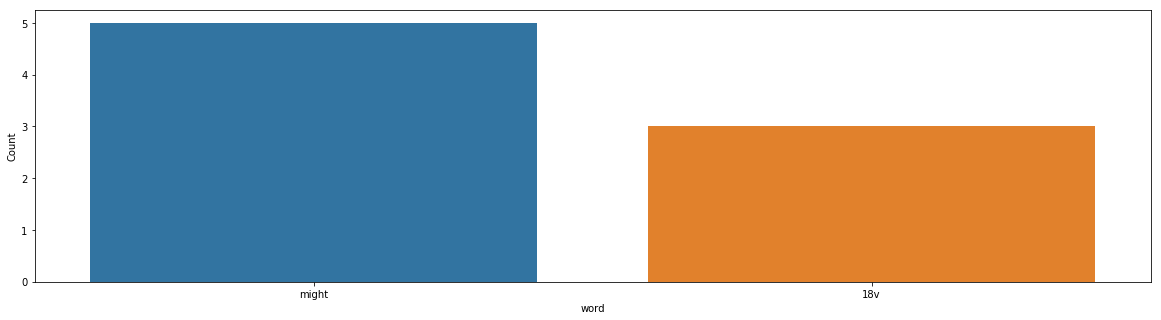

In [31]:
freq_words(exp,2)

In [32]:
# lemmatization

import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser', 'ner'])


def lemmatization(texts, tags=[ 'NOUN','ADJECTIVE','VERB']): # use verbs, adjectives and nouns 
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

tokenized_reviews = pd.Series(exp).apply(lambda x: x.split())
print(tokenized_reviews[1])

# delete most common words, such as relating the to product's name
#def delete_product_name(token_list):
 #   return [x for x in token_list if x not in ['kindle','fire','amazon', 'device', 'tablet', 'book', 'thing']]
#tokenized_reviews = tokenized_reviews.apply(delete_product_name)

reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['This', 'product', 'really', 'good,', 'handle', 'needs', 'improvement']
['product', 'handle', 'need', 'improvement']


In [33]:
[x for x in reviews_2[1] if x not in stop_words]

['product', 'handle', 'need', 'improvement']

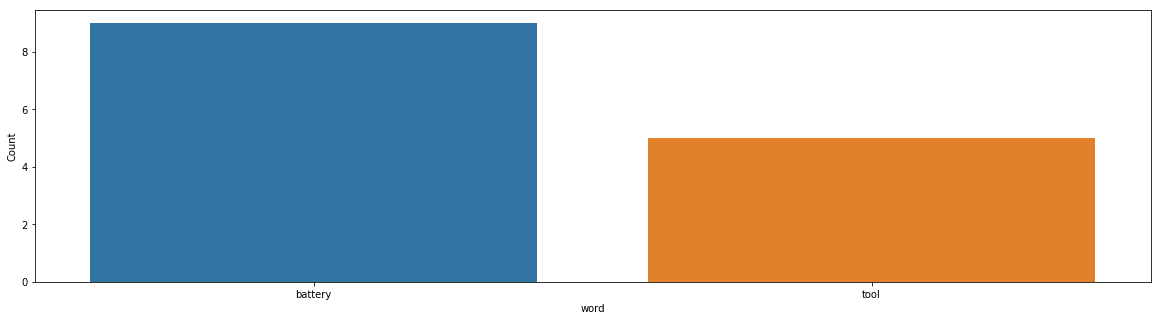

In [34]:
# replace review column with the cleaned version
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

# Visualize
freq_words(df['reviews'], 2)

### Modelling

### LDA

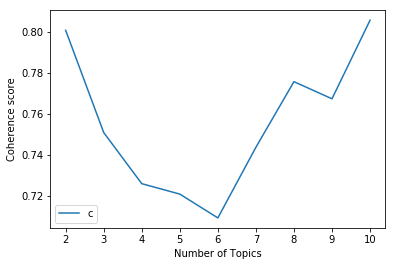

In [35]:
from gensim.models.coherencemodel import CoherenceModel
dictionary = corpora.Dictionary(reviews_2)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# check coherence score to decide number of topics 
c_v_score = []
for i in range(2,11):
    lda_model = LDA(corpus = doc_term_matrix, id2word = dictionary, num_topics = i, random_state = 44,
                chunksize = 1000, passes = 50)
    c_v_score.append(CoherenceModel(model=lda_model, texts=reviews_2, dictionary=dictionary, coherence='c_v').get_coherence())

# plot the score
# plot the coherence score
x = range(2, 11)
plt.plot(x, c_v_score)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
# train the model on optimal number of topics 
lda_model = LDA(corpus = doc_term_matrix, id2word = dictionary, num_topics = c_v_score.index(max(c_v_score))+1, random_state = 44,
                chunksize = 1000, passes = 50)

In [37]:
# get the topics
lda_model.print_topics()

[(0,
  '0.016*"improvement" + 0.016*"handle" + 0.016*"need" + 0.016*"product" + 0.016*"pace" + 0.016*"operate" + 0.016*"plywood" + 0.016*"package" + 0.016*"pack" + 0.016*"review"'),
 (1,
  '0.016*"improvement" + 0.016*"handle" + 0.016*"need" + 0.016*"product" + 0.016*"pace" + 0.016*"operate" + 0.016*"plywood" + 0.016*"package" + 0.016*"pack" + 0.016*"review"'),
 (2,
  '0.103*"need" + 0.103*"improvement" + 0.103*"handle" + 0.103*"product" + 0.010*"pace" + 0.010*"operate" + 0.010*"plywood" + 0.010*"package" + 0.010*"pack" + 0.010*"review"'),
 (3,
  '0.016*"improvement" + 0.016*"handle" + 0.016*"need" + 0.016*"product" + 0.016*"pace" + 0.016*"operate" + 0.016*"plywood" + 0.016*"package" + 0.016*"pack" + 0.016*"review"'),
 (4,
  '0.016*"battery" + 0.016*"tool" + 0.016*"blade" + 0.016*"saw" + 0.016*"cut" + 0.016*"18v" + 0.016*"slimline" + 0.016*"take" + 0.016*"think" + 0.016*"include"'),
 (5,
  '0.099*"battery" + 0.056*"tool" + 0.045*"blade" + 0.034*"buy" + 0.034*"cut" + 0.023*"circular" + 

In [38]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\banva\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
5     -0.076279 -0.0       1        1  94.618340
2      0.096630 -0.0       2        1   3.818781
8     -0.002907  0.0       3        1   0.223269
7     -0.002907 -0.0       4        1   0.223269
6     -0.002907  0.0       5        1   0.223269
4     -0.002907 -0.0       6        1   0.223269
3     -0.002907  0.0       7        1   0.223269
1     -0.002907  0.0       8        1   0.223269
0     -0.002907  0.0       9        1   0.223269, topic_info=   Category      Freq           Term     Total  loglift  logprob
4   Default  8.000000        battery  8.000000  30.0000  30.0000
54  Default  4.000000           tool  4.000000  29.0000  29.0000
5   Default  3.000000          blade  3.000000  28.0000  28.0000
17  Default  2.000000            cut  2.000000  27.0000  27.0000
8   Default  2.000000            buy  2.000000  26.0000  26.0000
51  Default  1.000000          think  1.000000  25.0000  25.0000
50  Default  1.000000           take  1.000000  24.0000  24.0000
57  Default  1.000000           work  1.000000  23.0000  23.0000
24  Default  1.000000        include  1.000000  22.0000  22.0000
49  Default  1.000000       slimline  1.000000  21.0000  21.0000
46  Default  1.000000            saw  1.000000  20.0000  20.0000
0   Default  1.000000            18v  1.000000  19.0000  19.0000
10  Default  1.000000       circular  1.000000  18.0000  18.0000
33  Default  1.000000           need  1.000000  17.0000  17.0000
12  Default  1.000000  consideration  1.000000  16.0000  16.0000
41  Default  1.000000        package  1.000000  15.0000  15.0000
52  Default  1.000000        thought  1.000000  14.0000  14.0000
15  Default  1.000000         couple  1.000000  13.0000  13.0000
7   Default  1.000000          brand  1.000000  12.0000  12.0000
48  Default  1.000000          seize  1.000000  11.0000  11.0000
19  Default  1.000000       etcetera  1.000000  10.0000  10.0000
55  Default  1.000000           want  1.000000   9.0000   9.0000
39  Default  1.000000           pace  1.000000   8.0000   8.0000
25  Default  1.000000           know  1.000000   7.0000   7.0000
36  Default  1.000000        operate  1.000000   6.0000   6.0000
43  Default  1.000000         rebate  1.000000   5.0000   5.0000
56  Default  1.000000            way  1.000000   4.0000   4.0000
30  Default  1.000000         middle  1.000000   3.0000   3.0000
18  Default  1.000000           deal  1.000000   2.0000   2.0000
3   Default  1.000000            bag  1.000000   1.0000   1.0000
..      ...       ...            ...       ...      ...      ...
44   Topic9  0.003258         review  1.077331   0.3033  -4.1109
40   Topic9  0.003258           pack  1.077331   0.3033  -4.1109
28   Topic9  0.003258           look  1.077331   0.3033  -4.1109
27   Topic9  0.003258           line  1.077331   0.3033  -4.1109
26   Topic9  0.003258           lean  1.077331   0.3033  -4.1109
25   Topic9  0.003258           know  1.077331   0.3033  -4.1109
23   Topic9  0.003258           inch  1.077331   0.3033  -4.1109
22   Topic9  0.003258        imagine  1.077331   0.3033  -4.1109
21   Topic9  0.003258         ignore  1.077331   0.3033  -4.1109
1    Topic9  0.003258          allow  1.077331   0.3033  -4.1109
19   Topic9  0.003258       etcetera  1.077331   0.3033  -4.1109
2    Topic9  0.003258          argue  1.077331   0.3033  -4.1109
29   Topic9  0.003258           love  1.077331   0.3033  -4.1109
15   Topic9  0.003258         couple  1.077331   0.3033  -4.1109
12   Topic9  0.003258  consideration  1.077331   0.3033  -4.1109
11   Topic9  0.003258  configuration  1.077331   0.3033  -4.1109
9    Topic9  0.003258           cell  1.077331   0.3033  -4.1109
7    Topic9  0.003258          brand  1.077331   0.3033  -4.1109
6    Topic9  0.003258          brake  1.077331   0.3033  -4.1109
3    Topic9  0.003258            bag  1.077331   0.3033  -4.1109
18   Topic9  0.003258           deal  

In [39]:
#import modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

# functions
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

# function for creating lsa model
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

# function for computing coherence values
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# function for ploting coherence value
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

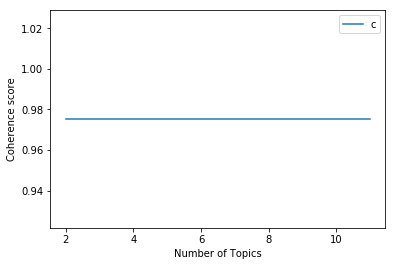

In [40]:
# plot the coherence plot 
start,stop,step=2,12,1
plot_graph(reviews_2,start,stop,step)

In [41]:
# train the model 
number_of_topics=3
words=10
clean_text = reviews_2
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

[(0, '0.611*"battery" + 0.339*"tool" + 0.272*"blade" + 0.204*"buy" + 0.204*"cut" + 0.136*"18v" + 0.136*"circular" + 0.136*"include" + 0.136*"saw" + 0.136*"think"'), (1, '-0.500*"product" + -0.500*"improvement" + -0.500*"handle" + -0.498*"need" + 0.021*"battery" + 0.012*"tool" + 0.009*"blade" + 0.007*"cut" + 0.007*"buy" + 0.005*"include"')]


In [42]:
# print topics 
model.print_topics()

[(0,
  '0.611*"battery" + 0.339*"tool" + 0.272*"blade" + 0.204*"buy" + 0.204*"cut" + 0.136*"18v" + 0.136*"circular" + 0.136*"include" + 0.136*"saw" + 0.136*"think"'),
 (1,
  '-0.500*"product" + -0.500*"improvement" + -0.500*"handle" + -0.498*"need" + 0.021*"battery" + 0.012*"tool" + 0.009*"blade" + 0.007*"cut" + 0.007*"buy" + 0.005*"include"')]